In [ ]:
! nvidia-smi

Thu Jun 15 02:19:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
!pip install tqdm
from tqdm import tqdm
from torchsummary import summary
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt

from model10 import *
from utils10 import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train = datasets.MNIST('../data/MNIST', train=True, download=True, transform=train_transforms())
# The dataset named "MNIST" is being called from within the torchvision available datasets
# MNIST is a dataset containing handwritten digits
# The training part of the dataset is downloaded to ../data location
# This is also the Extract (E) part of the ETL process where we are going to extract the dataset from raw data
test = datasets.MNIST('../data/MNIST', train=False, download=True, transform=test_transforms())
# The test part of the dataset is downloaded to ../data location

100%|██████████| 9912422/9912422 [00:00<00:00, 104596405.03it/s]


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 109823838.46it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23847243.51it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7260110.05it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

device = torch.device("cuda" if cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=2, pin_memory=True)
# Batch Size is a tunable parameter that tells us how many images can be sent in parallel to the model.
# This depends on the available memory and can be increased/decreased accordingly. This is tuned after the model is ran and based on available memory

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# trainloader is sort of "for" loop for us which will allow to look at or load a lot of images (~batch_size) at same time
# torch.utils.data.DataLoader wraps a dataset and provides access to the underlying data

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
# test till help to check accuracy of our model

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CUDA Available? True


In [ ]:
#return_image_stats(train)
# Since the train data is already Normalized, we will not get the actual mean and std values

torch.Size([128, 1, 28, 28])
torch.Size([128])


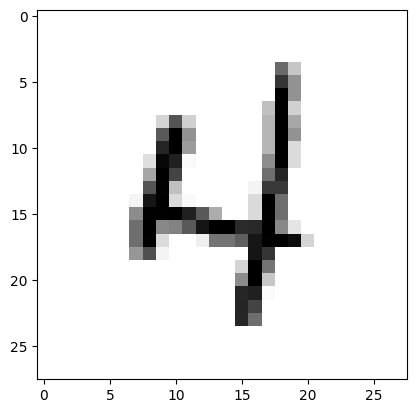

In [ ]:
return_single_image(train_loader)

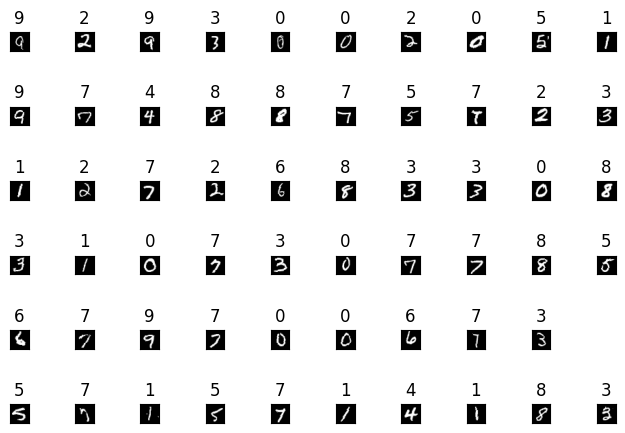

In [ ]:
return_dataset_images(train_loader,60)

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.070674367249012 Batch_id=468 Accuracy=87.21: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]



Test set: Average loss: 0.0733, Accuracy: 9793/10000 (97.93%)

EPOCH: 2


Loss=0.11057167500257492 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]



Test set: Average loss: 0.0404, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.06147606670856476 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]



Test set: Average loss: 0.0334, Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.10741426795721054 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]



Test set: Average loss: 0.0245, Accuracy: 9919/10000 (99.19%)

EPOCH: 5


Loss=0.1141946092247963 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]



Test set: Average loss: 0.0282, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.07477942109107971 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]



Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.019106004387140274 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]



Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.027890004217624664 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]



Test set: Average loss: 0.0241, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.005310505162924528 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]



Test set: Average loss: 0.0228, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.017821388319134712 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]



Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.01403127983212471 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]



Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.004336776211857796 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]



Test set: Average loss: 0.0202, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.06698401272296906 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]



Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.08558335155248642 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]



Test set: Average loss: 0.0198, Accuracy: 9945/10000 (99.45%)

EPOCH: 15


Loss=0.025890879333019257 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]



Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)



In [ ]:
train_losses

[tensor(2.2947, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2959, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2748, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2628, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2419, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2488, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2412, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1967, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2031, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1498, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1657, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1465, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1019, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0934, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0791, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1034, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

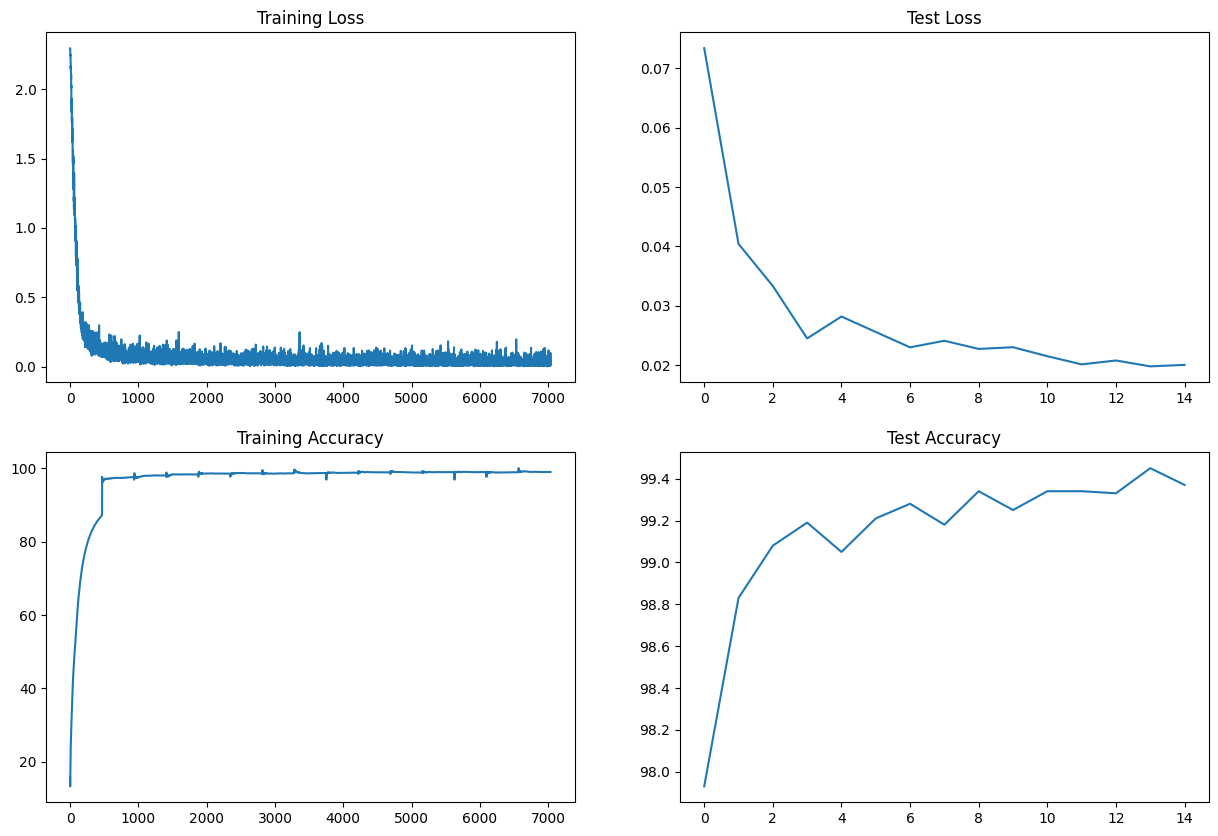

In [ ]:
draw_graphs(train_losses, train_acc, test_losses, test_acc)